<a href="https://colab.research.google.com/github/dyjdlopez/demo-hybrid-quantum-nn/blob/main/demo_hqn_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Quantum Neural Networks Part 2: Quantum-ready Training with Parameter-shift Rule

In [1]:
!pip install nvidia-cusparse-cu12 nvidia-cublas-cu12 nvidia-cuda-runtime-cu12 custatevec_cu12
!pip install pennylane pennylane-lightning-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 4.7 MB/s eta 0:00:00
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (21.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64",

In [2]:
import pennylane as qml

from torch.autograd import Function
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

from pennylane import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## 1. Importing the Data (Two-Moon Dataset)

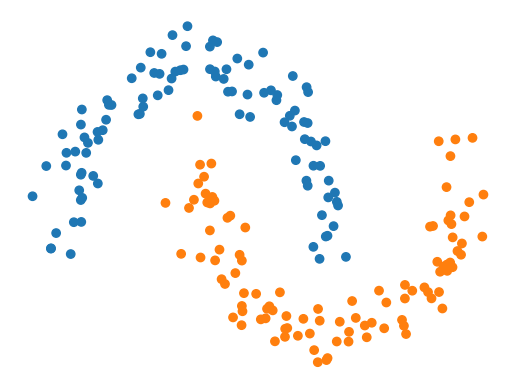

In [85]:
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [86]:
BATCH_SIZE = 2
data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

## 2. Defining the Quantum Layer

In [87]:

device = "cuda"

In [98]:
n_qubits = 2
dev = qml.device("lightning.gpu", wires=n_qubits)

@qml.qnode(dev)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [99]:
n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [100]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.forward(thetas)

        ctx.save_for_backward(thetas, expectation_z)

        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros((BATCH_SIZE,thetas.size()[1],2))

        for i in range(thetas.size()[1]):
            shift_right = torch.clone(thetas)

            shift_right[:,i] += ctx.shift

            shift_left = torch.clone(thetas)
            shift_left[:,i] -= ctx.shift

            expectation_right = ctx.quantum_circuit(shift_right).to(device)
            expectation_left = ctx.quantum_circuit(shift_left).to(device)
            gradients[:,i,:] = 0.5 * (expectation_right - expectation_left) * grad_output.float().to(device)

        grads = torch.sum(gradients, axis =2)


        return grads, None, None

In [101]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = qlayer
        self.shift = shift

    def forward(self, inputs):
        ans = QuantumFunction.apply(inputs, self.quantum_circuit, self.shift)

        return ans

In [102]:
class Model(nn.Module): ## Last FNC is Quantum (Quantum Header)
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,2)
        self.fc2 = nn.Linear(2,2)
        self.fc3 = QuantumLayer(torch.tensor(np.pi / 2))
        self.fc4 = nn.Linear(2,2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(torch.float32)))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x.to('cpu'))).to(device)
        # x = self.softmax(self.fc4(x)) ## uncomment for dressed-quantum layer

        return x

In [103]:
def model_opt(net, train_loader, epochs=5, batch_size=BATCH_SIZE):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
    net.to(device)
    metrics = {
        'loss': []
    }
    EPOCHS = epochs
    for epoch in tqdm(range(EPOCHS)):  # loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(tqdm(train_loader, 0)):

            x_batch, y_batch = data

            if x_batch.sum() != 0 or y_batch.sum() != 0:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()


                preds = net(x_batch)

                loss = criterion(preds, y_batch)

                loss.backward()
                optimizer.step()
                running_loss += loss.item() *batch_size

                del x_batch
                del y_batch

                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader)


        # if epoch == EPOCHS-1:
        print(f'Train\tLoss: {np.round(epoch_loss,10)}')
        metrics['loss'].append(epoch_loss)
    return net, metrics, optimizer

In [104]:
model = Model().cuda()
model, metrics, opts = model_opt(model, data_loader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.3445775473


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.3036890584


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.280487259


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2632765621


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2504036653


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2400466579


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2313148797


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.223588782


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2167032343


  0%|          | 0/100 [00:00<?, ?it/s]

Train	Loss: 1.2109007186


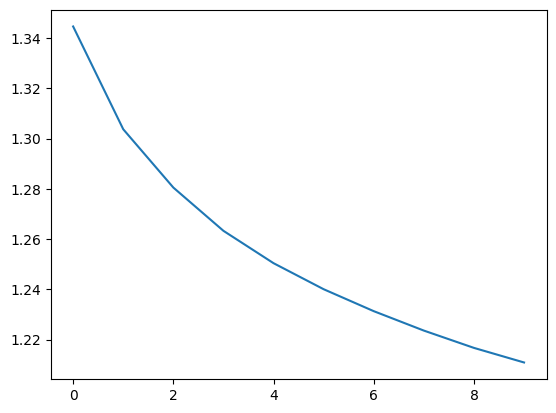

In [105]:
plt.plot(metrics['loss'])